In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy import signal as sig
import statsmodels.api as sm
import seaborn as sns
import warnings
from time import time
import copy 
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('data/valve1/1.csv',sep=';',index_col='datetime',parse_dates=True)

In [3]:
ind_start, ind_end = data.anomaly[data.anomaly == 1].index[0],data.anomaly[data.anomaly == 1].index[1]

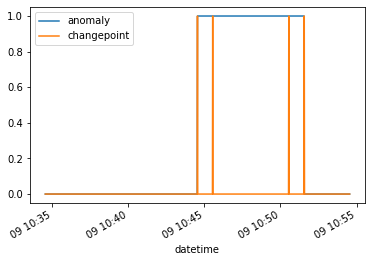

In [4]:
data.anomaly.plot()
data.changepoint.plot()
plt.legend()

In [5]:
from datetime import datetime 

In [6]:
bin_metric = data.anomaly.copy()
numenta_time= '30 sec'
true_items = list(data.anomaly[data.changepoint==1].values)

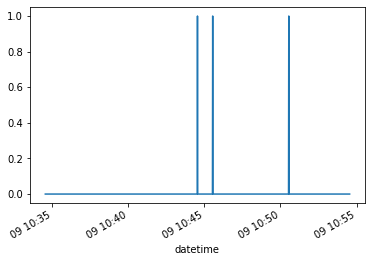

In [7]:
(data.anomaly * data.changepoint).plot()

In [8]:
len(data)

1145

In [13]:
3 + 743 + 1 + 398

1145

In [101]:
def evaluating_change_point(true,prediction, metric='nab',numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'
                
    """
    
    def binary(true,prediction):      
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
            true_ =   true == 1 
            prediction_ = prediction == 1
            TP = (true_ * prediction_).sum()
            TN = (~true_ * ~prediction_).sum()
            FP = (~true_ * prediction_).sum()
            FN = (true_ * ~prediction_).sum()
            return TP,TN,FP,FN
            
        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_       
    
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
    
    def average_delay(detecting_boundaries, prediction):
        
        def single_average_delay(detecting_boundaries, prediction):
            missing = 0
            detectHistory = []
            for couple in detecting_boundaries:
                t1 = couple[0]
                t2 = couple[1]
                if prediction[t1:t2].sum()==0:
                    missing+=1
                else:
                    detectHistory.append(prediction[prediction ==1][t1:t2].index[0]-t1)
            return missing, detectHistory
            
        
        if type(prediction) != type(list()):
            missing, detectHistory = single_average_delay(detecting_boundaries, prediction)
        else:
            missing, detectHistory = 0, []
            for i in range(len(prediction)):
                missing_, detectHistory_ = single_average_delay(detecting_boundaries[i], prediction[i])
                missing, detectHistory = missing+missing_, detectHistory+detectHistory_

        print('Average delay',pd.Series(detectHistory).mean())
        print(f'Missing values: {missing}')
    
    def evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
        """
        Scoring labeled time series by means of
        Numenta Anomaly Benchmark methodics

        Parameters
        ----------
        detecting_boundaries: list of list of two float values
            The list of lists of left and right boundary indices
            for scoring results of labeling
        prediction: pd.Series with timestamp indices, in which 1 
            is change point, and 0 in other case. 
        table_of_coef: pandas array (3x4) of float values
            Table of coefficients for NAB score function
            indeces: 'Standart','LowFP','LowFN'
            columns:'A_tp','A_fp','A_tn','A_fn'


        Returns
        -------
        Scores: numpy array, shape of 3, float
            Score for 'Standart','LowFP','LowFN' profile 
        Scores_null: numpy array, shape 3, float
            Null score for 'Standart','LowFP','LowFN' profile             
        Scores_perfect: numpy array, shape 3, float
            Perfect Score for 'Standart','LowFP','LowFN' profile  
        """
        def single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
            if table_of_coef is None:
                table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                                     [1.0,-0.22,1.0,-1.0],
                                      [1.0,-0.11,1.0,-2.0]])
                table_of_coef.index = ['Standart','LowFP','LowFN']
                table_of_coef.index.name = "Metric"
                table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

            alist = detecting_boundaries.copy()
            prediction = prediction.copy()

            Scores,Scores_perfect,Scores_null=[],[],[]
            for profile in ['Standart','LowFP','LowFN']:       
                A_tp = table_of_coef['A_tp'][profile]
                A_fp = table_of_coef['A_fp'][profile]
                A_fn = table_of_coef['A_fn'][profile]
                def sigm_scale(y,A_tp,A_fp,window=1):
                    return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

                #First part
                score = 0
                if len(alist)>0:
                    score += prediction[:alist[0][0]].sum()*A_fp
                else:
                    score += prediction.sum()*A_fp
                #second part
                for i in range(len(alist)):
                    if i<=len(alist)-2:
                        win_space = prediction[alist[i][0]:alist[i+1][0]].copy()
                    else:
                        win_space = prediction[alist[i][0]:].copy()
                    win_fault = prediction[alist[i][0]:alist[i][1]]
                    slow_width = int(len(win_fault)/4)

                    if len(win_fault) + slow_width >= len(win_space):
        #                    не совсем так правильно лелать
                        print('большая ширина плавного переходы сигмойды')
                        win_fault_slow = win_fault.copy()
                    else:
                        win_fault_slow= win_space[:len(win_fault)  +  slow_width]

                    win_fp = win_space[-len(win_fault_slow):]

                    if win_fault_slow.sum() == 0:
                        score+=A_fn
                    else:
                        #берем первый индекс
                        tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault),len(win_fault_slow)-len(win_fault)))
                        tr_values= tr[tr==1].index[0]
                        tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                        score += tr_score
                        score += win_fp.sum()*A_fp
                Scores.append(score)
                Scores_perfect.append(len(alist)*A_tp)
                Scores_null.append(len(alist)*A_fn)
            return np.array([np.array(Scores),np.array(Scores_null) ,np.array(Scores_perfect)])
       #=-----         
        if type(prediction) != type(list()):
            matrix = single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=table_of_coef)
        else:
            matrix = np.zeros((3,3))
            for i in range(len(prediction)):
                matrix_ = single_evaluate_nab(detecting_boundaries[i], prediction[i], table_of_coef=table_of_coef)
                matrix = matrix + matrix_      
                
        desc = ['Standart','LowFP','LowFN'] 
        for t in range(3):
            print(desc[t],' - ', round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]),2))
            
            
    #=========================================================================
    if type(true) != type(list()):
        true_items = true[true==1].index
    else:
        true_items = [true[i][true[i]==1].index for i in range(len(true))]
        

    if not metric=='binary':
        def single_detecting_boundaries(true,numenta_time,true_items):
            detecting_boundaries=[]
            td = pd.Timedelta(numenta_time) if numenta_time is not None else pd.Timedelta((true.index[-1]-true.index[0])/len(true_items))  
            for val in true_items:
                detecting_boundaries.append([val,val + td])
            return detecting_boundaries
        
        if type(true) != type(list()):
            detecting_boundaries = single_detecting_boundaries(true=true,numenta_time=numenta_time,true_items=true_items)
        else:
            detecting_boundaries=[]
            for i in range(len(true)):
                detecting_boundaries.append(single_detecting_boundaries(true=true[i],numenta_time=numenta_time,true_items=true_items[i]))

    if metric== 'nab':
        evaluate_nab(detecting_boundaries,prediction)
    elif metric=='average_delay':
        average_delay(detecting_boundaries,prediction)
    elif metric== 'binary':
        binary(true,prediction)
        
    



    


In [102]:
a= evaluating_change_point([data.changepoint,data.changepoint],
                        [bin_metric,bin_metric]
                        ,metric='binary',numenta_time='30 sec')

False Alarm Rate 34.88 %
Missing Alarm Rate 25.0 %


In [104]:
predicted = data.changepoint.copy()
predicted.index= predicted.index + pd.Timedelta('20 sec')

In [106]:
a= evaluating_change_point(data.changepoint,predicted,metric='nab',numenta_time='30 sec')

Standart  -  99.98
LowFP  -  99.98
LowFN  -  99.99


In [75]:
a[0]

[[DatetimeIndex(['2020-03-09 10:44:33', '2020-03-09 10:45:33',
                 '2020-03-09 10:50:33', '2020-03-09 10:51:34'],
                dtype='datetime64[ns]', name='datetime', freq=None),
  DatetimeIndex(['2020-03-09 10:45:03', '2020-03-09 10:46:03',
                 '2020-03-09 10:51:03', '2020-03-09 10:52:04'],
                dtype='datetime64[ns]', name='datetime', freq=None)],
 [DatetimeIndex(['2020-03-09 10:44:33', '2020-03-09 10:45:33',
                 '2020-03-09 10:50:33', '2020-03-09 10:51:34'],
                dtype='datetime64[ns]', name='datetime', freq=None),
  DatetimeIndex(['2020-03-09 10:45:03', '2020-03-09 10:46:03',
                 '2020-03-09 10:51:03', '2020-03-09 10:52:04'],
                dtype='datetime64[ns]', name='datetime', freq=None)]]